In [1]:
# https://colab.research.google.com/github/DhavalTaunk08/NLP_scripts/blob/master/sentiment_analysis_using_roberta.ipynb#scrollTo=HMqQTafXEaei

In [1]:
!nvidia-smi

Tue Oct 11 14:21:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    Off  | 00000000:03:00.0 Off |                  N/A |
| 23%   30C    P8     9W / 250W |    102MiB / 12188MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro P6000        Off  | 00000000:81:00.0 Off |                  Off |
| 26%   

In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from collections import defaultdict
from textwrap import wrap
from datetime import datetime
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
df1 =pd.read_csv('/users/kent/jmaharja/drugAbuse/input/Tweets_Spring_Summer_2021_coded.csv',
                lineterminator='\n',
                skipinitialspace=True,
                )
df1['label']= 1
df1.drop(df1.columns[[0, 2,3,4]], axis=1, inplace=True)
# df1

In [76]:
df2 =pd.read_csv('/users/kent/jmaharja/drugAbuse/input/2020_01_31_CleanedTweets.csv',
                lineterminator='\n',
                skipinitialspace=True
                )
df2.drop(df22.columns[[0, 1]], axis=1, inplace=True)
df2.rename({'text': 'Tweet'}, axis=1, inplace=True)
df2['label'] = 0

In [97]:
df3 =pd.read_csv('/users/kent/jmaharja/drugAbuse/temp/test_scripts/tweets_small.csv',
                lineterminator='\n',
                skipinitialspace=True
                )
# df3.drop(df2.columns[[0, 1]], axis=1, inplace=True)
df3.rename({'text': 'Tweet'}, axis=1, inplace=True)
df3['label']= 1
# df3= df3[:200]
# df3

,Tweet,created_at,_matched_terms,_matched_substrs,label
0,Mike McDaniel gets the game ball after his fir...,Sun Sep 11 22:51:45 +0000 2022,['Crack'],[],1
1,Great show with our friends Surf Monster(@band...,Mon Sep 12 16:20:19 +0000 2022,['acid'],['acid'],1
2,Dawg the sun ain’t even out &amp; the bees som...,Mon Sep 12 16:20:31 +0000 2022,['Crack'],[],1
3,@LeBatardShow @DarthAmin Did Amin party with @...,Mon Sep 12 16:20:41 +0000 2022,['Shrooms'],[],1
4,If the border is secure then why has enough fe...,Mon Sep 12 16:20:41 +0000 2022,['Fentanyl'],[],1
...,...,...,...,...,...
299,I don’t wanna have to pause my video every 3 s...,Thu Sep 15 21:03:30 +0000 2022,[],['meth'],1
300,@Lyricsoftheda14 @jmadmart And I'd like to tea...,Thu Sep 15 21:04:40 +0000 2022,['coca'],[],1
301,Starz is starting to behave like the CdubbaU. ...,Thu Sep 15 21:07:19 +0000 2022,[],['black tar'],1
302,I used to feel some type a way because I wasn’...,Thu Sep 15 21:08:31 +0000 2022,['meth'],['meth'],1


In [98]:
df4= df22[50001:50200]
# df4
# df3.to_csv('testdata.csv')
df3 = pd.concat([df3,df4])
df3.shape

(503, 5)

In [88]:
df = pd.concat([df1,df2])
# df

# DATA PREPROCESSING

In [10]:
# #choosing sequence length
# token_lens = []
# for txt in df.Tweet:
#   tokens = tokenizer.encode(txt)
#   token_lens.append(len(tokens))
# sns.distplot(token_lens)
# plt.xlim([0, 200])
# plt.xlabel('Token count')

# MAX_LEN = 80

In [10]:
MAX_LEN = 128
from transformers import RobertaTokenizerFast
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

# Create the tokenizer from a trained one
tokenizer_folder = '/users/kent/jmaharja/drugAbuse/output/sept2022/TokRoBERTa'
tokenizer = RobertaTokenizerFast.from_pretrained(tokenizer_folder, max_len=MAX_LEN)

In [11]:
from torch.utils.data import Dataset
class Tweet_DataSet(Dataset):
   def __init__(self, data, tokenizer, max_len):
    self.data = data
    self.tokenizer = tokenizer
    self.max_len = max_len
  
   def __len__(self):
    return len(self.data)
  
   def __getitem__(self, index:int):
    data_row = self.data.iloc[index]
    tweet = data_row.Tweet
    labels = data_row['label']
    encoding = tokenizer.encode_plus(tweet,
                                     None,
                                     max_length = MAX_LEN,
                                     truncation=True,
                                     pad_to_max_length=True,
                                     add_special_tokens=True,
                                     padding='max_length',
                                     return_token_type_ids=True)

    return {
      'tweet_text': tweet,
      'input_ids': torch.tensor(encoding.input_ids, dtype=torch.long),
      'attention_mask':  torch.tensor(encoding.attention_mask, dtype=torch.long),
      'token_type_ids': torch.tensor(encoding.token_type_ids, dtype=torch.long),
      'targets': torch.tensor(labels, dtype=torch.long)
    }

In [99]:
# from sklearn.model_selection import train_test_split
# df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
# # df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
# df_val = df_test
df_test = df3
df_train.shape, df_val.shape, df_test.shape

((22020, 2), (2447, 2), (503, 5))

In [100]:
df_test

,Tweet,created_at,_matched_terms,_matched_substrs,label
0,Mike McDaniel gets the game ball after his fir...,Sun Sep 11 22:51:45 +0000 2022,['Crack'],[],1
1,Great show with our friends Surf Monster(@band...,Mon Sep 12 16:20:19 +0000 2022,['acid'],['acid'],1
2,Dawg the sun ain’t even out &amp; the bees som...,Mon Sep 12 16:20:31 +0000 2022,['Crack'],[],1
3,@LeBatardShow @DarthAmin Did Amin party with @...,Mon Sep 12 16:20:41 +0000 2022,['Shrooms'],[],1
4,If the border is secure then why has enough fe...,Mon Sep 12 16:20:41 +0000 2022,['Fentanyl'],[],1
...,...,...,...,...,...
50195,USER way man rid dick HTTPURL,NaN,NaN,NaN,0
50196,okay omg date cry,NaN,NaN,NaN,0
50197,USER USER USER USER USER USER USER USER… HTTPURL,NaN,NaN,NaN,0
50198,USER bolton tell truth cipollone meeting cipol...,NaN,NaN,NaN,0


In [101]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = Tweet_DataSet(df,tokenizer=tokenizer,max_len=max_len)
  return DataLoader(ds, batch_size=batch_size,num_workers=4)

BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [18]:
# from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel
# from transformers import RobertaModel, RobertaConfig, logging

class TweetModel(RobertaPreTrainedModel):
    def __init__(self, conf, n_classes):
        super(TweetModel, self).__init__(conf)
        self.roberta = transformers.RobertaModel.from_pretrained('/users/kent/jmaharja/drugAbuse/output/sept2022/RoBERTaMLM/', config=conf)
        self.drop_out = nn.Dropout(0.3)
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.classifier = nn.Linear(768, n_classes)
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.roberta(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.drop_out(pooler)
        output = self.classifier(pooler)
        return output


In [19]:
from transformers import RobertaConfig

config = RobertaConfig(
    vocab_size=8192,
    max_position_embeddings=514,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
    hidden_size=768,
    pad_token_id=1
)

model = TweetModel(config, 2)
model = model.to(device)

Some weights of the model checkpoint at /users/kent/jmaharja/drugAbuse/output/sept2022/RoBERTaMLM/ were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /users/kent/jmaharja/drugAbuse/output/sept2022/RoBERTaMLM/ and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stre

In [20]:
#training
EPOCHS = 16

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
loss_fn = nn.CrossEntropyLoss().to(device)

/users/kent/jmaharja/anaconda3/envs/crawler/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [21]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
     
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    targets = d["targets"].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

    big_val, big_idx = torch.max(outputs, dim=1)
    correct_predictions += torch.sum(big_idx == targets)

    loss = loss_fn(outputs, targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double()/n_examples, np.mean(losses)

In [22]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids
      )
      _, preds = torch.max(outputs, dim=1)
      correct_predictions += torch.sum(preds == targets)

      loss = loss_fn(outputs, targets)
      losses.append(loss.item())

  return correct_predictions.double()/n_examples, np.mean(losses)

In [23]:
from os.path import exists
# %%time

# set to True if you want to train the model
# otherwise use the existing trained model
FORCE_TRAIN = True

# download trained model
# !gdown --id 1QQ2d0_yFStL2rXz2eHoXpgRMvPWtMMeX

print(40*"*", 'Training')
current_time = datetime.now().strftime("%Y_%m_%d-%I_%M%p")
print(current_time)
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):


#   modelPath = "checkpoint/best_ftc_model_state.bin"
#   if (exists(modelPath) and FORCE_TRAIN == False ): # if model exists load it otherwise rebuild
#     torch.load(modelPath)
#     break # exit out of training
  

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(model, val_data_loader,loss_fn, device, len(df_val))

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    curr_time = datetime.now().strftime("%Y_%m_%d-%I_%M%p")
    torch.save(model.state_dict(), 'checkpoint/best_ftc_model_state'+'.bin')
    best_accuracy = val_acc

**************************************** Training
2022_10_10-12_10PM
Epoch 1/16
----------
Train loss 0.01734562913779704 accuracy 0.9959128065395095
Val   loss 0.011249478483210517 accuracy 0.9979566816510013

Epoch 2/16
----------
Train loss 0.002330970165363144 accuracy 0.999591280653951
Val   loss 0.013923454669210205 accuracy 0.9979566816510013

Epoch 3/16
----------
Train loss 0.0010539567551337164 accuracy 0.9997729336966394
Val   loss 0.024398817205133795 accuracy 0.9975480179812015

Epoch 4/16
----------
Train loss 0.0002726163259067234 accuracy 0.9999091734786557
Val   loss 0.02145222055013841 accuracy 0.998365345320801

Epoch 5/16
----------
Train loss 0.0014258105941890027 accuracy 0.9997729336966394
Val   loss 0.010397155367461162 accuracy 0.9987740089906008

Epoch 6/16
----------
Train loss 1.2021243661904219e-06 accuracy 1.0
Val   loss 0.009839680831151814 accuracy 0.9987740089906008

Epoch 7/16
----------
Train loss 4.915480968535347e-07 accuracy 1.0
Val   loss 0.010233

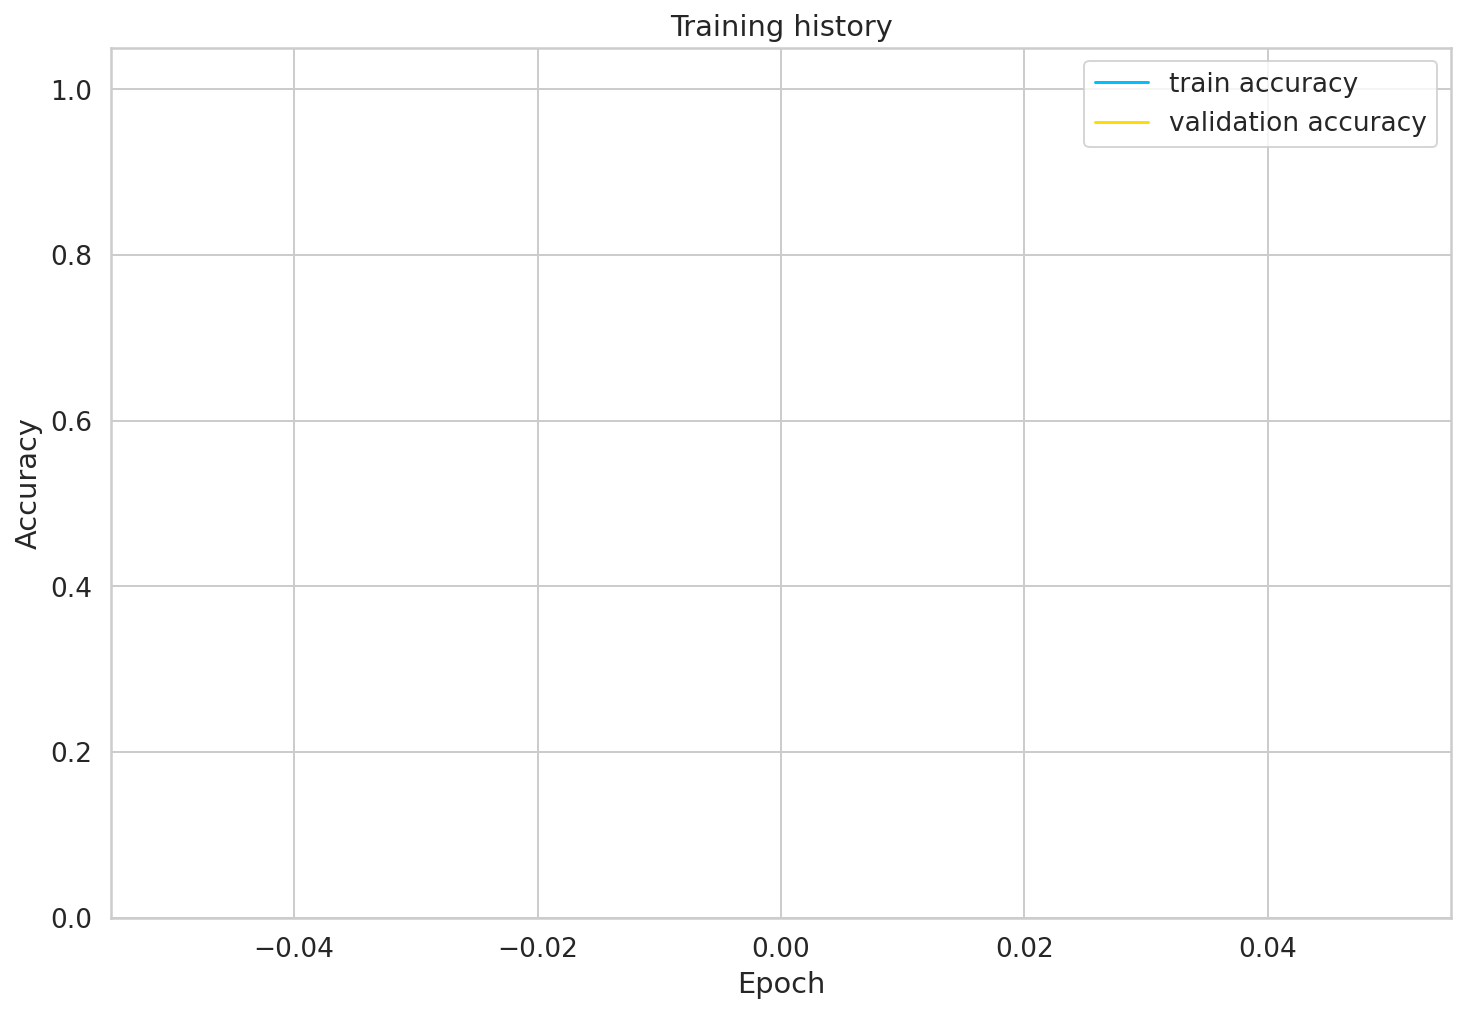

In [54]:
plt.plot(history['t_acc'], label='train accuracy')
plt.plot(history['v_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1.05]);
plt.savefig('images/training_history '+current_time+'.png')

In [53]:
t_acc = [x.cpu().data.numpy() for x in history['train_acc']]
v_acc = [y.cpu().data.numpy() for y in history['val_acc']]
t_acc

[array(0.99591281),
 array(0.99959128),
 array(0.99977293),
 array(0.99990917),
 array(0.99977293),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.)]

In [102]:
test_acc, _ = eval_model(model, test_data_loader, loss_fn, device, len(df_test))
test_acc.item()

0.9999999999999999

In [27]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      targets = d["targets"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
      _, preds = torch.max(outputs, dim=1)
      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [59]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model,test_data_loader)

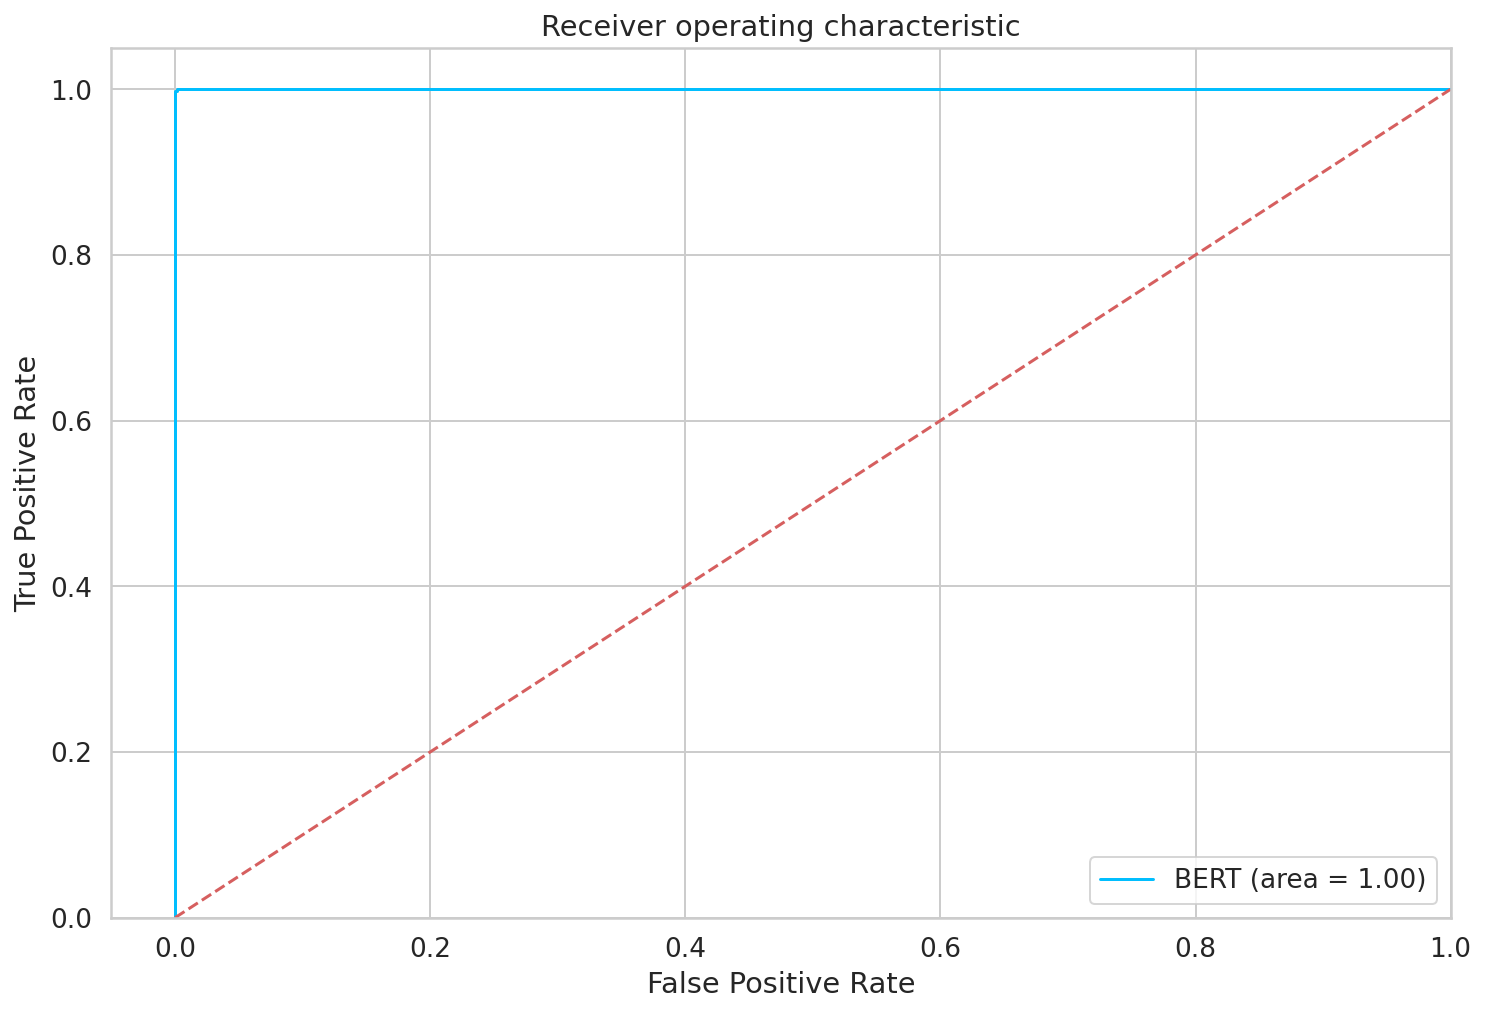

In [58]:
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test.numpy(), y_pred_probs[:, 1].numpy())
plt.figure()
plt.plot(fpr, tpr, label='BERT (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images/Log_ROC_'+ current_time +'.png')
plt.show()

In [60]:
y_pred_probs_pd = [y.numpy() for y in y_pred_probs]
someListOfLists = list(zip(y_review_texts, y_test.numpy(), y_pred.numpy(), y_pred_probs[:, 1:].numpy().squeeze(), y_pred_probs_pd ))
npa = np.asarray(someListOfLists)
dff = pd.DataFrame(someListOfLists, columns = ['readme', 'Real', 'Predicted', 'Pred-prob', 'All Pred-probs' ])
dff

/tmp/ipykernel_23410/1137194375.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  npa = np.asarray(someListOfLists)


,readme,Real,Predicted,Pred-prob,All Pred-probs
0,I crack up at the amount of grace people exten...,1,1,1.0,"[4.6802427e-08, 1.0]"
1,I crack myself up sometimes 🤣,1,1,1.0,"[5.5098372e-08, 1.0]"
2,@cschieffer @acaseofthegolf1 Or the bottom wit...,1,1,1.0,"[4.037485e-08, 1.0]"
3,@mymixtapez Get plugged in today real and reli...,1,1,1.0,"[4.324325e-08, 1.0]"
4,Ever notice how some people relentlessly &amp;...,1,1,1.0,"[4.5370257e-08, 1.0]"
...,...,...,...,...,...
4995,I swear we are so close to witnessing the repu...,1,1,1.0,"[4.1947025e-08, 1.0]"
4996,I’ll always crack up at this,1,1,1.0,"[5.303855e-08, 1.0]"
4997,Boogie crack me up lmao,1,1,1.0,"[5.491393e-08, 1.0]"
4998,@HolgerDanske18 @mmpadellan This is White Powe...,1,1,1.0,"[3.823956e-08, 1.0]"


In [61]:
print(classification_report(y_test, y_pred, target_names=['Y', 'N']))

              precision    recall  f1-score   support

           Y       0.00      0.00      0.00         0
           N       1.00      0.99      1.00      5000

    accuracy                           0.99      5000
   macro avg       0.50      0.50      0.50      5000
weighted avg       1.00      0.99      1.00      5000



/users/kent/jmaharja/anaconda3/envs/crawler/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/users/kent/jmaharja/anaconda3/envs/crawler/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/users/kent/jmaharja/anaconda3/envs/crawler/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

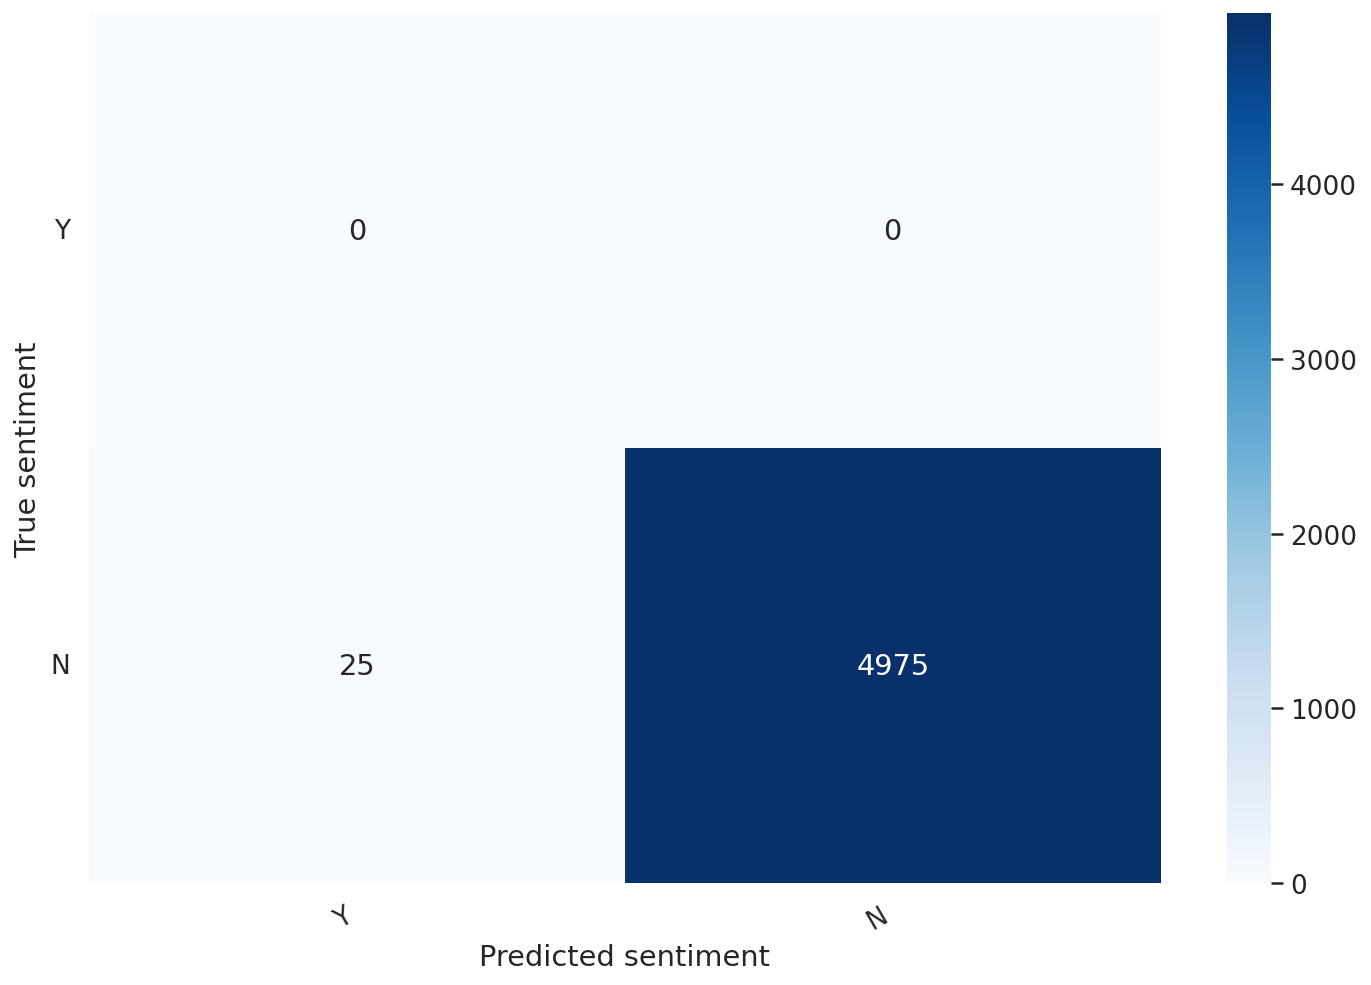

In [62]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=['Y', 'N'], columns=['Y', 'N'])
show_confusion_matrix(df_cm)